# PyRADISE

In [1]:
%reset -f
import numpy as np
import sys, time, copy,os
sys.path.append('../')
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pkl


# PySSD
import seaborn as sns
from PySSD.Distribution import Distribution,Gaussian
from PySSD.Detuning import LinearDetuning
from PySSD.Dispersion import Dispersion
from PySSD.Integrator import FixedTrapezoidalIntegrator, SimpsonIntegrator, TrapzIntegrator, DblquadIntegrator


# PyRADISE
import PyRADISE 
from PyRADISE.Detuning import LinearDetuningClass 
from PyRADISE.Noise    import NoiseClass
from PyRADISE.Machine  import MachineClass
from PyRADISE.Grid     import Grid1DClass,Grid2DClass
from PyRADISE.Solver   import SolverClass
from PyRADISE.StabilityDiagram import calc_Stability_Diagram
from PyRADISE.Coefficients import DiffCoeffGrid

# Plotting preparation
from plot_configuration import *
np.set_printoptions(precision=3,suppress=True) 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
plt.close('all')

Finished configuring the plots.


In [2]:
%matplotlib notebook
pltstorage = '04_Plots_Diffusion/'
pklstorage = '01_Output/'
flag_sidebyside = 1


def sci_not(num,dec):
    if num>0:
        exp = int(np.log10(num)+100)-100
        sci = (r"$%.10f"%(num/10**exp))[:dec+2+1*(dec>0)]+r"\cdot10^{%d}$"%exp
    else:
        sci = '$0$'
    return sci

# Lebedev scan

In [3]:
################
## Initialize ##
deletables = ['DiffE', 'DiffN', 'DiffS', 'DiffW', 'DriftE', 'DriftN', 'DriftS', 'DriftW', 'FV_M',
'psi0', 'psis', 'psis1Dx', 'psis1Dy', 'psis2D', 'psisPosX', 'psisPosY',
'dPsis1DdJx', 'dPsis1DdJy', 'dPsis2DdJx', 'dPsis2DdJy']

pltstorage = '04_Plots_Diffusion/LebedevPaper/'

markers = ['*','x','+','1','2','3','4','>','<','o','^','v']


base = 4
logfac = np.logspace(-1,1,7,base=base)
bfac = [-1,-0.7,-0.35,0,0.35,.7,1]
noisefac1= np.array([0,1/5,1/2,1,1,1,1])
noisefac2= np.array([1,1,1,1,1/2,1/5,0])
noisefac3= [1/2,1/2,1/5,1/10,1/20,1/50,0]



scanType =2

basename = "lebscan_2D_Nc700r_tmax24h_"
addnames = ["a|a0=%.2e" , "aKconst_a|a0=%.2e" , "g0|g=%.2e" , "g|Kconst_g0|g=%.2e",
            "K|K0=%.2e" , "b|a0=%.2e" , "rel(Kx,Ky)=%.2e" , "Kxconst_rel(Kx,10Ix)=%.2e"]
legends = [r"$a/a_0$", r"$a/a_0$", r"$g_0/g$" ,r"$g_0/g$" ,
           r"$\sigma_{kx}/\sigma_0$", r"$b/a$" , 
#           r"$(\sigma_{kx}-\sigma_{ky})/(\sigma_{kx}+\sigma_{ky})$",
           r"rel$(\sigma_{kx}\!-\!\sigma_{ky})$",r"rel$(\sigma_{kx}\!-\!10\sigma_{Ix})$"]
#           r"$(\sigma_{kx}-10\sigma_{Ix})/(\sigma_{kx}+10\sigma_{Ix})$"]
addlegends=["",", $a\sigma_{kx}=$const","",", $g/\sigma_{kx}=$const","","","",""]

scanname = basename + addnames[scanType]
legend = legends[scanType]
xvalss = [logfac,logfac,logfac,logfac,logfac,bfac,(noisefac1-noisefac2)/(noisefac1+noisefac2),(noisefac1-noisefac2)/(noisefac1+noisefac2)]
xvals = xvalss[scanType]
# if scanType in [0,1,2,3,4]:
#     xvals = logfac
# elif scanType in [5]:
#     xvals = bfac
# else:
#     xvals = (noisefac1-noisefac2)/(noisefac1+noisefac2)

    
flag_oneplot = 1

In [4]:
###############
## Load calc ##


calcs = []
# for ifile, filename in enumerate(filenames):
# for ia,a_to_a0 in enumerate(a_to_a0s):
for i in range(7):
    filename = scanname%(xvals[i])
    try:
        with open(pklstorage+filename+'_S2.pkl','rb') as pklfile:
            print('Loading ',pklfile.name)
            calc = pkl.load(pklfile)

        ## Modify result
        if not 'modified'  in dir(calc) :
            calc.SD_calcEffectiveStrength(plane=0,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=np.nan)
            calc.SD_calcEffectiveStrength(plane=1,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=np.nan)
            with open(pklstorage+filename+'_S2.pkl','wb') as pklfile:
                print('Dumping ',pklfile.name)
                calc.modified=True
                pkl.dump(calc,pklfile)

        # Delete unnecessary data from this plotting
        for deletable in deletables:
            setattr(calc, deletable, None)
        
#         if i ==0:
#             with open(pklstorage+filename+'_S3.pkl','wb') as pklfile:
#                     print('Dumping ',pklfile.name)
#                     calc.modified=True
#                     pkl.dump(calc,pklfile)
        
        calcs.append(calc)
        print(calc.M.N.sigma_ibsx, calc.M.N.sigma_ibsy,calc.M.Q.ax,calc.M.Q.bx,calc.M.N.sigma_kx)
    except:
        print('Could not find %s'%filename)
        calcs.append(None)

Loading  01_Output/lebscan_2D_Nc700r_tmax24h_g0|g=2.50e-01_S2.pkl
0 0 5e-05 -3.5e-05 0.0005
Loading  01_Output/lebscan_2D_Nc700r_tmax24h_g0|g=3.97e-01_S2.pkl
0 0 5e-05 -3.5e-05 0.0005
Loading  01_Output/lebscan_2D_Nc700r_tmax24h_g0|g=6.30e-01_S2.pkl
0 0 5e-05 -3.5e-05 0.0005
Loading  01_Output/lebscan_2D_Nc700r_tmax24h_g0|g=1.00e+00_S2.pkl
0 0 5e-05 -3.5e-05 0.0005
Loading  01_Output/lebscan_2D_Nc700r_tmax24h_g0|g=1.59e+00_S2.pkl
0 0 5e-05 -3.5e-05 0.0005
Loading  01_Output/lebscan_2D_Nc700r_tmax24h_g0|g=2.52e+00_S2.pkl
0 0 5e-05 -3.5e-05 0.0005
Loading  01_Output/lebscan_2D_Nc700r_tmax24h_g0|g=4.00e+00_S2.pkl
0 0 5e-05 -3.5e-05 0.0005


[-0.    -0.01  -0.027 -0.057 -0.103 -0.213 -0.439]
[ 0.    -0.    -0.004 -0.015 -0.03  -0.045 -0.045]


<IPython.core.display.Javascript object>


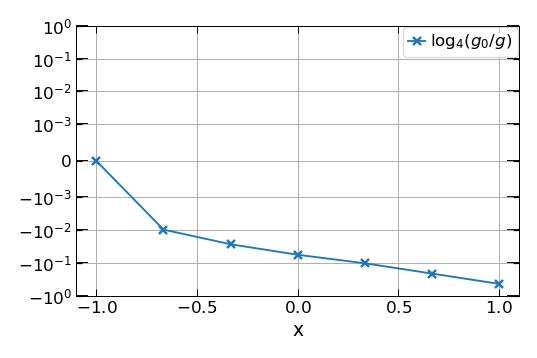

[-1.    -0.667 -0.333  0.     0.333  0.667  1.   ] [-0.    -0.01  -0.027 -0.057 -0.103 -0.213 -0.439]


<IPython.core.display.Javascript object>


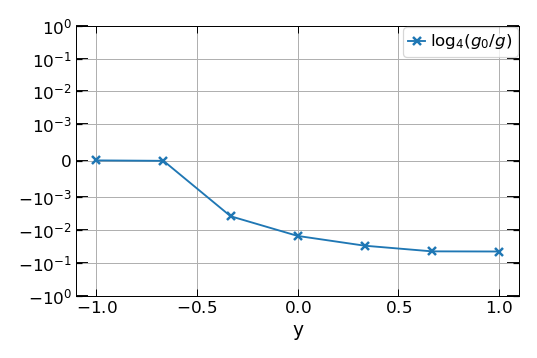

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [5]:
xvals = xvalss[scanType]

growth_rate_x = np.empty(np.size(xvals))
growth_rate_y = np.empty(np.size(xvals))
growth_rate_x[:] = np.nan
growth_rate_y[:] = np.nan

for i , calc in enumerate(calcs):
    try:
        growth_rate_x[i] = np.diff(calc.effectiveStrengthx[:2])/np.diff(calc.tsSD[:2])*calc.time_scale
        growth_rate_y[i] = np.diff(calc.effectiveStrengthy[:2])/np.diff(calc.tsSD[:2])*calc.time_scale
    except:
        print('ERROR',np.diff(calc.effectiveStrengthx[:2]))
        None
print(growth_rate_x)
print(growth_rate_y)
    


if xvals[-1]==base:
    label =r'$\mathrm{log}_{%d}($'%base+legend+r'$)$'+addlegends[scanType]
    x = np.log(xvals)/np.log(base)
else:
    print(xvals)
    label = legend
    x = np.array(xvals)
if 1:
    fig1=plt.figure()
    ind = np.isfinite(growth_rate_x)
    print(x,growth_rate_x)
    plt.plot(x[ind],growth_rate_x[ind],'x-',label=label)
    plt.legend(loc=0)
    plt.xlabel('x')
    ax1 = plt.gca()
    
    fig2=plt.figure()
    ind = np.isfinite(growth_rate_y)
    plt.semilogy(x[ind],growth_rate_y[ind],'x-',label=label)
    plt.legend(loc=0)
    plt.xlabel('y')
    
    ax2 = plt.gca()
    for ax in [ax1,ax2]:
        ax.tick_params(axis='y',length=10,width=1.5)
        ax.tick_params(axis='y',which='minor',length=5,width=1)
        ax.grid(True,which="both")
        ax.set_yscale('symlog', linthreshy=0.001)
        ax.set_ylim(-1,1)
    fig1.tight_layout()
    fig2.tight_layout()
data = {'label':label,'x':x,'growth_rate_x':growth_rate_x,'growth_rate_y':growth_rate_y}
with open(pklstorage+'GR0_%s.pkl'%(scanname%xvals[-1]),'wb') as pklfile:
    pkl.dump(data,pklfile)

<IPython.core.display.Javascript object>


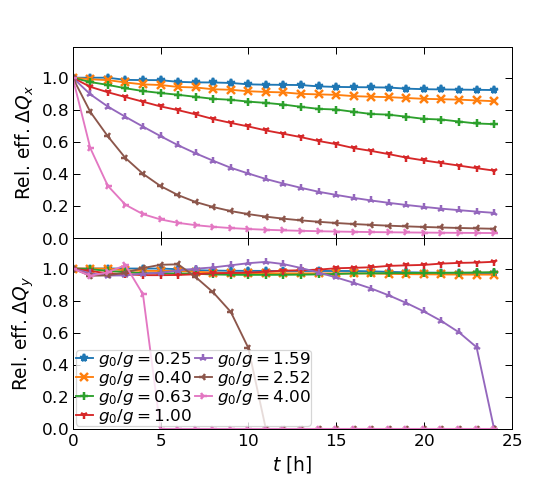

0 [1.    1.    1.    0.986 0.985 0.985 0.974 0.971 0.97  0.967 0.959 0.956
 0.955 0.954 0.946 0.943 0.941 0.94  0.939 0.932 0.928 0.927 0.926 0.924
 0.923]
a=5.00e-05 , b=-3.50e-05 , g=4.00e-02
1 [1.    0.99  0.985 0.97  0.958 0.955 0.942 0.939 0.928 0.925 0.916 0.911
 0.908 0.899 0.896 0.893 0.885 0.881 0.879 0.873 0.868 0.866 0.863 0.858
 0.853]
a=5.00e-05 , b=-3.50e-05 , g=2.52e-02
2 [1.    0.973 0.955 0.934 0.917 0.905 0.893 0.881 0.868 0.862 0.851 0.843
 0.833 0.818 0.806 0.802 0.787 0.774 0.769 0.757 0.743 0.739 0.727 0.714
 0.71 ]
a=5.00e-05 , b=-3.50e-05 , g=1.59e-02
3 [1.    0.943 0.909 0.879 0.85  0.821 0.798 0.771 0.742 0.718 0.696 0.671
 0.651 0.629 0.605 0.586 0.561 0.543 0.523 0.502 0.484 0.468 0.452 0.436
 0.42 ]
a=5.00e-05 , b=-3.50e-05 , g=1.00e-02
4 [1.    0.897 0.82  0.756 0.695 0.636 0.579 0.528 0.482 0.438 0.403 0.368
 0.34  0.313 0.289 0.269 0.251 0.234 0.22  0.206 0.194 0.183 0.174 0.165
 0.157]
a=5.00e-05 , b=-3.50e-05 , g=6.30e-03
5 [1.    0.787 0.634 0.499 0.4

In [6]:
xvals=xvalss[scanType]

mpl.rcParams.update({'lines.markeredgewidth':2,
                     'lines.markersize':6})
if flag_oneplot:
    fig1,axs = plt.subplots(2,1,sharex=True,figsize=(figwidth, figheight*1.38))
    fig2=fig1
    ax1 =axs[0] ; ax2=axs[1]
else:
    fig1,ax1=plt.subplots(1,figsize=(figwidth*0.7, figheight*1))
    fig2,ax2=plt.subplots(1)


# r'$\mathrm{log}_{10}(a/a_0)$'
for i , calc in enumerate(calcs):
    print(i,calc.effectiveStrengthx)
    xval=xvals[i]
    ylabel=xlabel=legend+'$=%.2f$'%xval+addlegends[scanType]
    
    try:
        outx=calc.SD_plotEffectiveStrength(plane=0,label=xlabel,flag_plotInscribed=0,ax=ax1,
                                           iTime_step=1,fmt_string='%s-'%markers[i], minIntensity=0)
        outy=calc.SD_plotEffectiveStrength(plane=1,label=ylabel,flag_plotInscribed=0,ax=ax2,
                                           iTime_step=1,fmt_string='%s-'%markers[i])

        print('a=%.2e , b=%.2e , g=%.2e'%(calc.M.Q.ax,calc.M.Q.bx,calc.M.gx))
    except:
        None

# ax1.legend(loc=1)
add=''#'(J_x,J_y)'
ax1.set_ylabel(r'Rel. eff. $\Delta Q_x%s$'%add)
ax2.set_ylabel(r'Rel. eff. $\Delta Q_y%s$'%add)

ymax = [1.49,1.19][1]
ax1.set_xlim(0,25)
for ax in [ax1,ax2]:
    ax.set_yticks(0.2*np.arange(8))
    ax.set_ylim(ymax-1.19,ymax)
    ax.grid(False)


# if flag_sidebyside:
#     for fig in [fig1,fig2]:
#         fig.set_size_inches(figwidth*0.6, figheight*1)
#         fig.tight_layout()
if flag_oneplot:
    ax1.set_xlabel(None)
    fig1.subplots_adjust(hspace=0.)
    ax1.get_legend().remove()
    if scanType in [0,1,2,3,4,5,7]:
        ax2.legend(loc=3,ncol=2,columnspacing=0.2,borderaxespad=0.2,borderpad=0,labelspacing=0)
    else:
        ax2.legend(loc=[(0.01,.91),3][0],ncol=2,columnspacing=0.2,borderaxespad=0.2,borderpad=0,labelspacing=0)

    
if flag_oneplot:
    fig1.savefig(pltstorage+'RelDQ_'+scanname%xvals[-1]+'nogrid.pdf')
else:
    fig1.savefig(pltstorage+'RelDQx_'+scanname%xvals[-1]+'.pdf')
    fig2.savefig(pltstorage+'RelDQy_'+scanname%xvals[-1]+'.pdf')

<IPython.core.display.Javascript object>


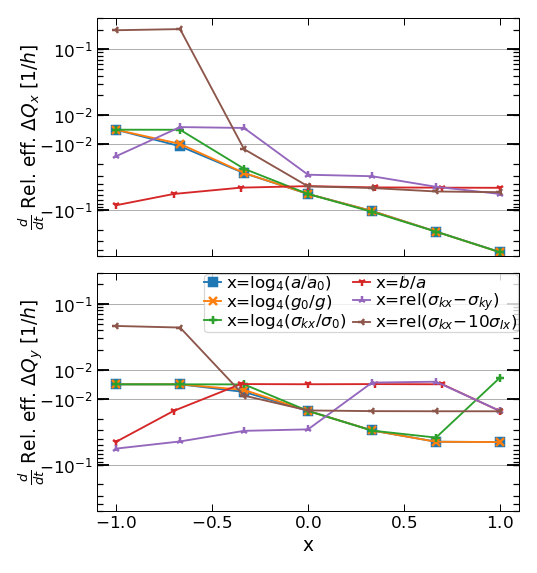

01_Output/GR0_lebscan_2D_Nc700r_tmax24h_a|a0=4.00e+00.pkl
{'x': array([-1.   , -0.667, -0.333,  0.   ,  0.333,  0.667,  1.   ]), 'growth_rate_y': array([ 0.   , -0.   , -0.005, -0.015, -0.03 , -0.045, -0.045]), 'growth_rate_x': array([-0.   , -0.011, -0.027, -0.057, -0.103, -0.213, -0.436]), 'label': '$\\mathrm{log}_{4}($$a/a_0$$)$'}
01_Output/GR0_lebscan_2D_Nc700r_tmax24h_g0|g=4.00e+00.pkl
{'x': array([-1.   , -0.667, -0.333,  0.   ,  0.333,  0.667,  1.   ]), 'label': '$\\mathrm{log}_{4}($$g_0/g$$)$', 'growth_rate_x': array([-0.   , -0.01 , -0.027, -0.057, -0.103, -0.213, -0.439]), 'growth_rate_y': array([ 0.   , -0.   , -0.004, -0.015, -0.03 , -0.045, -0.045])}
01_Output/GR0_lebscan_2D_Nc700r_tmax24h_K|K0=4.00e+00.pkl
{'x': array([-1.   , -0.667, -0.333,  0.   ,  0.333,  0.667,  1.   ]), 'label': '$\\mathrm{log}_{4}($$\\sigma_{kx}/\\sigma_0$$)$', 'growth_rate_x': array([-0.   , -0.   , -0.024, -0.057, -0.107, -0.213, -0.439]), 'growth_rate_y': array([ 0.   , -0.   , -0.   , -0.015, -

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


In [7]:
# scannames = [
# "GR0_lebscan_2D_Nc700r_tmax24h_g|Kconst_g0|g=4.00e+00",
# "GR0_lebscan_2D_Nc700r_tmax24h_g0|g=4.00e+00",
# "GR0_lebscan_2D_Nc700r_tmax24h_aKconst_a|a0=4.00e+00",
# "GR0_lebscan_2D_Nc700r_tmax24h_a|a0=4.00e+00",
# ]


fig1,axs = plt.subplots(2,1,sharex=True,figsize=(figwidth, figheight*1.6))
ax1 =axs[0] ; ax2=axs[1]
cnt=0
for i,addname in enumerate(addnames):
    if i in [1,3]: continue
    xvals = xvalss[i]
    filename = "GR0_"+basename+addname%xvals[-1]
    try:
        with open(pklstorage+filename+'.pkl','rb') as pklfile:
            print(pklfile.name)
            data = pkl.load(pklfile)
        print(data)
        indx = data['growth_rate_x']<10
        indy = data['growth_rate_y']<10
        marker = [markers[cnt],'s'][cnt==0]
        cnt+=1
        ax1.semilogy(data['x'][indx],data['growth_rate_x'][indx],'%s-'%marker,label='x='+data['label'])
        ax2.semilogy(data['x'][indy],data['growth_rate_y'][indy],'%s-'%marker,label='x='+data['label'])
    except:
        print('%s is not ready'%scanname)

ax1.set_xlabel(None)

# ax1.get_legend().remove()
# ax2.legend(loc=(0,1))


yticks = []
for jj in range(4):
    start =(-1)**(jj%2)*10**(-2+jj//2)
    stop =(-1)**(jj%2)*10**(-1+jj//2)
    yticks=np.concatenate((yticks,np.linspace(start,stop,10)))

for ax in [ax1,ax2]:
    ylim = ax.get_ylim()
    if ylim[1]/ylim[0]<10:
        ax.set_ylim(10**np.floor(np.log10(ylim[0]))*.9,1.1*10**np.ceil(np.log10(ylim[1])))
    ax.tick_params(axis='y',length=10,width=1.5)
    ax.tick_params(axis='y',which='minor',length=5,width=1)
#     ax.grid(True,which="both")
    ax.grid(True,which='major',axis='y')
    
    ax.set_yscale('symlog', linthreshy=0.01,linscaley=.2)
    ax.set_yticks([-1,-0.1,-0.01,0.01,0.1,1])
    ax.set_yticks(yticks,minor=True) ;

ax1.legend(loc=0)
ax1.get_legend().remove()
ax2.legend(loc=[(0,.9),0][1],ncol=2,columnspacing=0.4,borderaxespad=0.1,borderpad=0,labelspacing=0)

ylabel = r'$\frac{d}{dt}$ Rel. eff. $\Delta Q_%s$ $[1/h]$'
for ia,ax in enumerate([ax1,ax2]):
    ax.set_ylabel(ylabel%['x','y'][ia],labelpad=-7)
    ax.set_ylim(-.5,.3)
    
ax2.set_xlabel('x')
fig1.tight_layout()
fig1.subplots_adjust(hspace=0.07)    
    
fig1.savefig(pltstorage+'RelDQ_t0_Lebedevscan.pdf')


# ABP forum scan

In [42]:
deletables = ['DiffE', 'DiffN', 'DiffS', 'DiffW', 'DriftE', 'DriftN', 'DriftS', 'DriftW', 'FV_M',
'psi0', 'psis', 'psis1Dx', 'psis1Dy', 'psis2D', 'psisPosX', 'psisPosY',
'dPsis1DdJx', 'dPsis1DdJy', 'dPsis2DdJx', 'dPsis2DdJy']

pltstorage = '04_Plots_Diffusion/'
###############
## Load calc ##

filenames = [
    "calc_Dt_ax1.20e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax5s_S2.pkl",
    "calc_Dt_ax1.40e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax20s_S2.pkl",
    "calc_Dt_ax1.60e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax100s_S1.pkl",
    "calc_Dt_ax2.00e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax11m_S2.pkl"]   

calcs = []
# for ifile, filename in enumerate(filenames):
# for ia,a_to_a0 in enumerate(a_to_a0s):
for i in range(3):
    filename = filenames[i]
    try:
        with open(pklstorage+filename,'rb') as pklfile:
            print('Loading ',pklfile.name)
            calc = pkl.load(pklfile)
        print('Loaded')

    except:
        print('Could not find %s'%filename)
        calcs.append(None)
        continue
        
        #         ## Modify result
#         if not 'modified'  in dir(calc) and 0:
#             calc.SD_calcEffectiveStrength(plane=0,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=np.nan)
#             calc.SD_calcEffectiveStrength(plane=1,flag_interpStrength=1,mode_R=0,flag_allDQ_R=1,maxmin_ratio=np.nan)
#             with open(pklstorage+filename+'_S2.pkl','wb') as pklfile:
#                 print('Dumping ',pklfile.name)
#                 calc.modified=True
#                 pkl.dump(calc,pklfile)

    # Delete unnecessary data from this plotting
    for deletable in deletables:
        setattr(calc, deletable, None)

#         if i ==0:
#             with open(pklstorage+filename+'_S3.pkl','wb') as pklfile:
#                     print('Dumping ',pklfile.name)
#                     calc.modified=True
#                     pkl.dump(calc,pklfile)
    calc.tsSD = calc.tsODE[calc.indexSD]
    calcs.append(calc)
    print(calc.M.N.sigma_ibsx, calc.M.N.sigma_ibsy,calc.M.Q.ax,calc.M.Q.bx,calc.M.N.sigma_kx)

Loading  01_Output/calc_Dt_ax1.20e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax5s_S2.pkl
Loaded
0 0 0.00012 -8.4e-05 0.0001
Loading  01_Output/calc_Dt_ax1.40e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax20s_S2.pkl
Loaded
0 0 0.00014 -9.799999999999998e-05 0.0001
Loading  01_Output/calc_Dt_ax1.60e-04_bx:ax-0.70_gx0e+00_BC0_2D_Kx1.0e-04_Ky0.0e+00_ibs0e+00-0e+00_iC3_reDQx-2.2e-04_imDQx3.6e-05_Nc700r_tmax100s_S1.pkl
Loaded
0 0 0.00016 -0.000112 0.0001


<IPython.core.display.Javascript object>


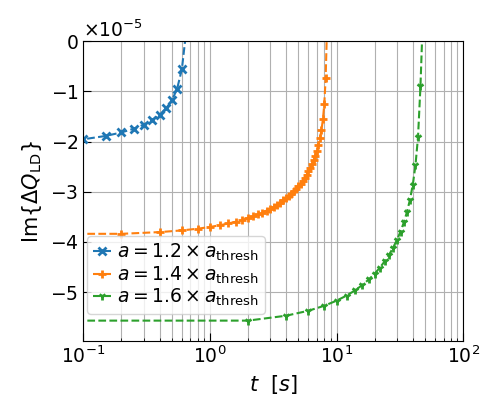

[-20.767 -20.167 -19.538 -18.879 -18.179 -17.432 -16.627 -15.711 -14.663
 -13.401 -11.798  -9.527  -5.616   2.08    0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.   ]
[-38.718 -38.384 -38.042 -37.704 -37.363 -37.02  -36.67  -36.323 -35.971
 -35.61  -35.251 -34.887 -34.515 -34.142 -33.761 -33.378 -32.982 -32.58
 -32.163 -31.741 -31.307 -30.86  -30.394 -29.918 -29.425 -28.914

In [66]:
# Print growthrate
figheightpres=5
plt.figure(figsize=(figwidth/1.2,figheightpres/1.2))
labels=r'$a=%.1f\times a_\mathrm{thresh}$'
for i,calc in enumerate(calcs):
    if i==3: continue
    plt.plot(calc.tsODE,calc.growthRatex[:calc.nt],'--%s'%markers[1+i],label=labels%(calc.M.Q.ax0/1e-4))
    print(calc.growthRatex*1e6)
    
plt.grid(True)
plt.ylim(top=0)
plt.ylabel(r"$\operatorname{Im}\{ \Delta Q_\mathrm{LD}\}$")
plt.xlabel(r'$t$  $[s]$')
plt.legend(loc=(0.01,0.09),labelspacing=0.07)
plt.xscale('log')
plt.xlim(0.1,100)
plt.grid(True,axis='x',which='minor')
plt.tight_layout()
plt.savefig(pltstorage+'NEW_becomeUnstable.eps')

In [144]:
from pprint import pprint
X=vars(calc)
Y=dir(calc)
print(Y)
for y in Y:
    try:
        print(y,np.size(X[y]))
    except:
        None
['DiffE', 'DiffN', 'DiffS', 'DiffW', 'DriftE', 'DriftN', 'DriftS', 'DriftW', 'FV_M',
'psi0', 'psis', 'psis1Dx', 'psis1Dy', 'psis2D', 'psisPosX', 'psisPosY',
'dPsis1DdJx', 'dPsis1DdJy', 'dPsis2DdJx', 'dPsis2DdJy']

['BC_V', 'DiffE', 'DiffN', 'DiffS', 'DiffW', 'DriftE', 'DriftN', 'DriftS', 'DriftW', 'FV_M', 'G', 'J1D_proj_x1D', 'J2D_proj_J1D', 'M', 'ND', 'SD_calcEffectiveStrength', 'SD_calcEvolution', 'SD_calcScaledPsi0', 'SD_calcStabilityMargin', 'SD_copyScaledPsi0', 'SD_plotEffectiveStrength', 'SD_plotSD', 'SD_plotStabilityMargin', 'SD_plotWaterfall', '_IC', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_calc_BC_V_1D', '_workerSD', '_worker_psix', '_worker_psiy', 'bool_IC_point', 'calc_BC_V', 'calc_Coeff', 'calc_FV_M', 'calc_InterpDist', 'cart_x', 'cart_y', 'cohDQsAllx', 'cohDQsAlly', 'cohDQs_halfIx', 'cohDQs_halfIy', 'cohDQs_psi0_scaledx', 'cohDQs_psi0_scaledy', 'dPsis1DdJx', 'dPsis1DdJy', 'dPsis2DdJx', '

['DiffE',
 'DiffN',
 'DiffS',
 'DiffW',
 'DriftE',
 'DriftN',
 'DriftS',
 'DriftW',
 'FV_M',
 'psi0',
 'psis',
 'psis1Dx',
 'psis1Dy',
 'psis2D',
 'psisPosX',
 'psisPosY',
 'dPsis1DdJx',
 'dPsis1DdJy',
 'dPsis2DdJx',
 'dPsis2DdJy']